In [1]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Sequential
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, zscore, rankdata
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import from_networkx, add_self_loops, to_undirected
from tqdm import tqdm
from torch.utils.data import Dataset
from torch_geometric.data import Dataset
from torch.nn import (BatchNorm1d, Dropout, Linear,
                      Module)
from torch_geometric.nn import (GCNConv, GATConv, SAGEConv, GlobalAttention,
                                global_mean_pool, ChebConv, MessagePassing)
from torch_geometric.nn import GINConv, Sequential as GINSequential


from torch.optim.lr_scheduler import StepLR




In [2]:
lines = []
with open('/Users/leopoldstevens/Desktop/projet_perso_neuro_AI/EEG_Decoder/EP1.01.txt', 'r') as file:
    for line in file:
        lines.append(line)
print(len(lines))

910476


In [3]:
print(lines[0])
print(lines[1])
print(lines[2])
print(lines[3])
print(lines[4])

67635	67635	EP	AF3	6	260	4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,437

In [4]:
split_ = lines[0].split()
for i in range(len(split_)):
    print(i, split_[i])

0 67635
1 67635
2 EP
3 AF3
4 6
5 260
6 4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4

In [5]:
event = []
digit = []
pos = []
data = []
line_counter = 0

data_df = pd.DataFrame(columns=['event', 'digit', 'pos', 'data'])

for line in tqdm(lines):
    if line_counter<14_00:
        split_line = line.split()
        event.append(split_line[1])
        digit.append(split_line[4])
        pos.append(split_line[3])
        data.append(split_line[6])
        line_counter+=1

data_df['event'] = event
data_df['digit'] = digit
data_df['pos'] = pos
data_df['data'] = data

num_events = data_df['event'].unique()
print(len(num_events))

del lines, event, digit, pos, data, num_events

print(data_df.head())
print(data_df.shape)

100%|██████████| 910476/910476 [00:01<00:00, 469614.28it/s]


100
   event digit  pos                                               data
0  67635     6  AF3  4395.384615,4382.564102,4377.435897,4387.17948...
1  67635     6   F7  4489.230769,4475.384615,4474.358974,4486.66666...
2  67635     6   F3  4538.461538,4528.717948,4524.615384,4526.15384...
3  67635     6  FC5  4207.692307,4205.641025,4200.512820,4194.35897...
4  67635     6   T7  4497.948717,4498.461538,4494.871794,4497.94871...
(1400, 4)


In [6]:
def process_data(x):
    data_list = [float(i) for i in x.split(',')]
    if len(data_list) < 240:
        return None
    return data_list[:240]

In [7]:
print(data_df['data'].values)

['4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,4370.769230,4380.000000,43

In [8]:
data_df['data'] = data_df['data'].apply(process_data)
data_df = data_df.dropna(subset=['data'])

data_df['event'] = data_df['event'].apply(float)
data_df['digit'] = data_df['digit'].apply(float)
data_df['digit'] = data_df['digit'].apply(lambda x: 10 if x == -1 else x)

scaler_per_row = 1
standard = 0

if scaler_per_row:
    if standard:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    data_df['data'] = data_df['data'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
else:
    if standard:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    all_data = np.concatenate(data_df['data'].values)
    all_data_reshaped = all_data.reshape(-1, 1)
    scaler.fit(all_data_reshaped)
    data_df['data'] = data_df['data'].apply(lambda x: scaler.transform(np.array(x).reshape(-1, 1)).flatten())
    del all_data


print(data_df.head(28))
print(data_df.shape)


      event  digit  pos                                               data
0   67635.0    6.0  AF3  [0.8441558461291976, 0.5194805129026889, 0.389...
1   67635.0    6.0   F7  [0.4296875010711574, 0.2187499966674693, 0.203...
2   67635.0    6.0   F3  [0.945205480183887, 0.684931497701271, 0.57534...
3   67635.0    6.0  FC5  [0.3678160878319545, 0.3218390768529531, 0.206...
4   67635.0    6.0   T7  [0.43749997714844824, 0.44999998903124094, 0.3...
5   67635.0    6.0   P7  [0.7246376991808319, 0.43478260255197654, 0.49...
6   67635.0    6.0   O1  [0.04797979926059881, 0.0, 0.00757575492711382...
7   67635.0    6.0   O2  [0.6770833297363197, 0.41666665820312687, 0.21...
8   67635.0    6.0   P8  [0.9480519487097325, 0.714285717903536, 0.2597...
9   67635.0    6.0   T8  [0.4999999906250139, 0.3942307712139552, 0.317...
10  67635.0    6.0  FC6  [0.8148148181584389, 0.59259259994856, 0.50925...
11  67635.0    6.0   F4  [1.0, 0.82208588891001, 0.7607361974933227, 0....
12  67635.0    6.0   F8  

In [9]:

# grouped_data = data_df.groupby(['pos', 'digit']).apply(lambda x: pd.DataFrame(x['data'].tolist()).mean().tolist())

# n_subplots = len(data_df['pos'].unique())
# fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(20, 80))

# # Create a color palette with 11 distinct colors
# palette = sns.color_palette("hsv", 11)

# for i, pos in enumerate(data_df['pos'].unique()):
#     pos_group = grouped_data.xs(pos)
#     for digit, data_series in pos_group.iteritems():
#         sns.lineplot(x=range(len(data_series)), y=data_series, ax=axes[i], color=palette[int(digit)], label=int(digit))

#     axes[i].set_title(f'Position: {pos}')
#     axes[i].legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()


In [10]:
pos_values = data_df['pos'].unique()
print(pos_values)
data_lengths = data_df['data'].apply(len)
unique_lengths = data_lengths.unique()
print(unique_lengths)
del data_lengths

['AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8' 'T8' 'FC6' 'F4' 'F8' 'AF4']
[240]


In [11]:
coordinates = {
    'AF3': {'phi': (129.9+89.7)/2,
            'theta': (52.2+41.0)/2},
    'F7': {'phi': 137.2,
            'theta': 83.1},
    'F3': {'phi': 129.9,
            'theta': 52.2},
    'FC5': {'phi': (137.2+129.9+173.9+180)/4 ,
            'theta': (83.1+52.2+95+45.2/4)},
    'T7': {'phi': 173.9,
            'theta': 95.0},
    'P7': {'phi': 216.1,
            'theta': 92.9},
    'O1': {'phi': 250.6,
            'theta': 89.2},
    'O2': {'phi': 287.5,
            'theta': 90.1},
    'P8': {'phi': 322.7,
            'theta': 94.9},
    'T8': {'phi': 3.2,
            'theta': 95.8},
    'FC6': {'phi': (-1.0+3.2+40.3+49.8)/4,
            'theta':(46.0+95.8+84.1+53.6)/4 },
    'F4': {'phi': 49.8,
            'theta': 53.6},
    'F8': {'phi': 40.3,
            'theta': 84.1},
    'AF4': {'phi': (89.7+49.8)/2,
            'theta': (41.0+53.6)/2}
}

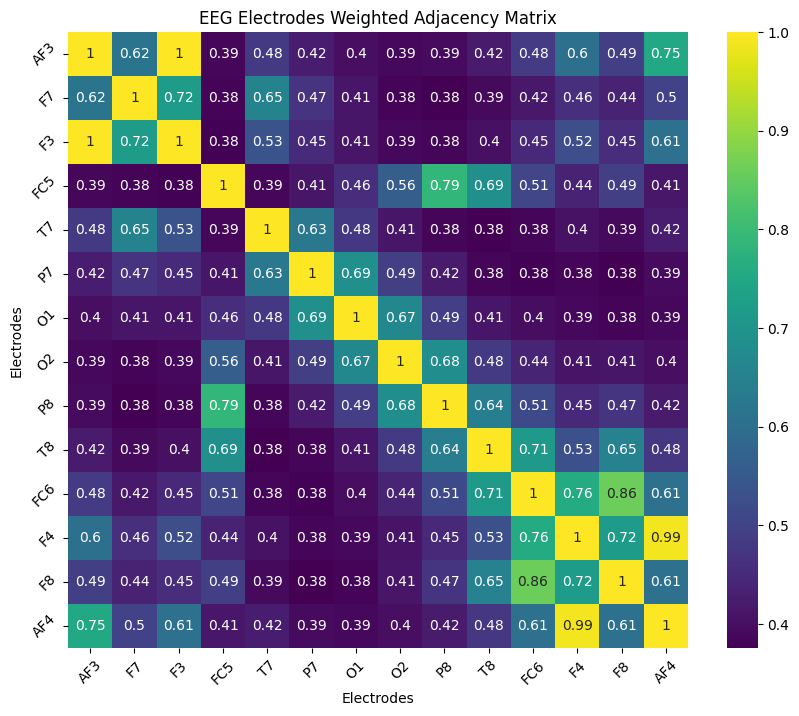

In [12]:
def spherical_to_cartesian(phi, theta):
    phi_rad = np.radians(phi)
    theta_rad = np.radians(theta)
    x = np.cos(phi_rad) * np.sin(theta_rad)
    y = np.sin(phi_rad) * np.sin(theta_rad)
    z = np.cos(theta_rad)
    return x, y, z

adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))

for i, (coord_i, values_i) in enumerate(coordinates.items()):
    x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
    for j, (coord_j, values_j) in enumerate(coordinates.items()):
        if i != j:
            x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
            d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
            w = 1 / np.sqrt(d)
            adjacency_matrix[i, j] = w

max_weight = adjacency_matrix.max()
adjacency_matrix[adjacency_matrix > 0] /= max_weight

np.fill_diagonal(adjacency_matrix, 1)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(adjacency_matrix, annot=True, cmap='viridis', ax=ax)

plt.title('EEG Electrodes Weighted Adjacency Matrix')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.xticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)
plt.yticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)

plt.show()


In [13]:
def calculate_spatial_weights(coordinates):

    num_nodes = len(coordinates)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i, coord_i in enumerate(coordinates.keys()):
        values_i = coordinates[coord_i]
        x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
        for j, coord_j in enumerate(coordinates.keys()):
            if i != j:
                values_j = coordinates[coord_j]
                x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
                d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
                w = 1 / d
                adjacency_matrix[i, j] = w

    max_weight = adjacency_matrix.max()
    adjacency_matrix[adjacency_matrix > 0] /= max_weight
    np.fill_diagonal(adjacency_matrix, 1)

    return adjacency_matrix



In [14]:
def reshape_data_for_correlation(df):
    mean_time_series = df.groupby('pos')['data'].apply(lambda x: np.mean(np.vstack(x.values), axis=0))
    time_series_array = np.stack(mean_time_series.values)
    
    return time_series_array

reshaped_data_for_cor = reshape_data_for_correlation(data_df)

def calculate_correlation_matrix(time_series_data):
    correlation_matrix = np.corrcoef(time_series_data)
    return correlation_matrix

correlation_matrix = calculate_correlation_matrix(reshaped_data_for_cor)

print(correlation_matrix.shape)

(14, 14)


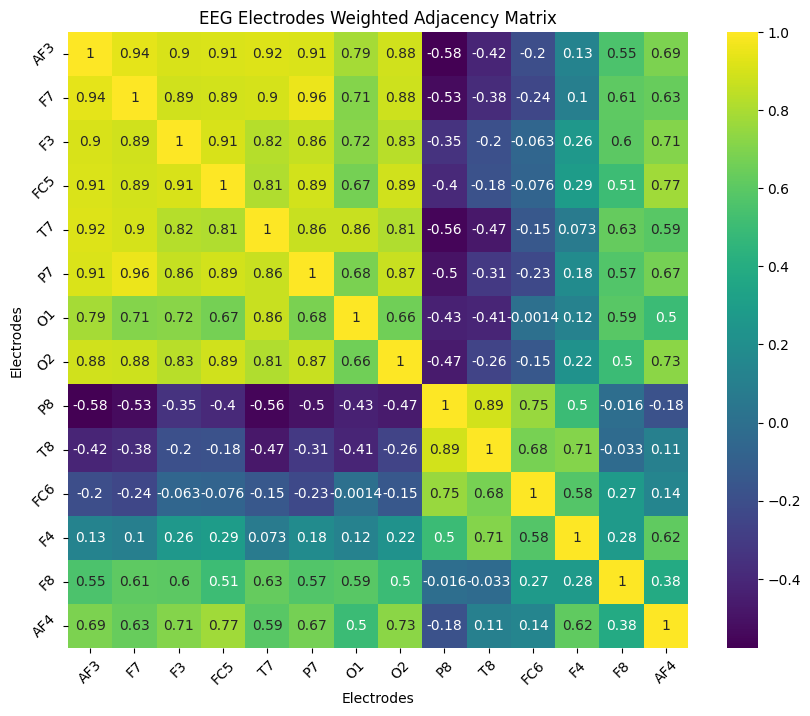

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', ax=ax)

plt.title('EEG Electrodes Weighted Adjacency Matrix')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.xticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)
plt.yticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)

plt.show()

In [16]:
def batch_graphs(x_batch, y_batch, edge_index_batch, edge_weight_batch):
    batched_x = []
    batched_edge_index = []
    batched_edge_weight = []
    batched_y = []
    batched_batch = []

    for i, (x, y, edge_index, edge_weight) in enumerate(zip(x_batch, y_batch, edge_index_batch, edge_weight_batch)):
        num_nodes = x.size(0)

        adjusted_edge_index = edge_index + torch.full_like(edge_index, i * num_nodes)

        batched_x.append(x)
        batched_edge_index.append(adjusted_edge_index)
        batched_edge_weight.append(edge_weight)

        if y.dim() == 0:
            y = y.unsqueeze(0)
        batched_y.append(y)

        batched_batch.append(torch.full((num_nodes,), i, dtype=torch.long))

    batched_x = torch.cat(batched_x, dim=0)
    batched_edge_index = torch.cat(batched_edge_index, dim=1)
    batched_edge_weight = torch.cat(batched_edge_weight, dim=0) if batched_edge_weight[0] is not None else None
    batched_y = torch.cat(batched_y, dim=0)
    batched_batch = torch.cat(batched_batch, dim=0)

    return batched_x, batched_y, batched_edge_index, batched_edge_weight, batched_batch


In [17]:
class EEG_LSTM_GNN_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, edge_index, edge_weight):
        self.dataframe = dataframe
        self.unique_events = dataframe['event'].unique()
        self.edge_index = to_undirected(edge_index)
        self.edge_index, _ = add_self_loops(self.edge_index)
        self.edge_weight = edge_weight

    def __len__(self):
        return len(self.unique_events)

    def __getitem__(self, idx):
        event_id = self.unique_events[idx]
        event_data = self.dataframe[self.dataframe['event'] == event_id]

        x = np.array([row.data for row in event_data.itertuples(index=False)])
        x = torch.tensor(x, dtype=torch.float)
        y = event_data.iloc[0]['digit']

        batch = torch.full((x.size(0),), idx, dtype=torch.long)

        return x, y, self.edge_index.clone(), self.edge_weight.clone(), batch


In [18]:
from torch.utils.data import Subset

def custom_train_test_split(dataset, test_size=0.2, random_state=42):
    np.random.seed(random_state)

    indices = np.arange(len(dataset))
    print(indices.size)
    np.random.shuffle(indices)

    split_idx = int(len(dataset) * (1 - test_size))
    print(split_idx)

    train_indices, test_indices = indices[:split_idx], indices[split_idx:]

    print('split done')

    train_dataset = Subset(dataset, train_indices)
    print(train_dataset)
    test_dataset = Subset(dataset, test_indices)
    print(test_dataset)

    return train_dataset, test_dataset

In [19]:
def add_jitter(time_series, noise_level):
    noise = np.random.normal(loc=0, scale=noise_level, size=time_series.shape)
    return time_series + noise

def augment_training_set(training_dataset, noise_level=0.01):
    augmented_data = []

    for data in training_dataset:
        x, y, edge_index, edge_weight, batch = data
        x_augmented = add_jitter(x.numpy(), noise_level=noise_level * np.std(x.numpy()))
        x_augmented = torch.tensor(x_augmented, dtype=torch.float)

        augmented_data.append((x, y, edge_index, edge_weight, batch))
        augmented_data.append((x_augmented, y, edge_index, edge_weight, batch))

    return augmented_data

In [20]:
G = nx.complete_graph(14)
edge_index = from_networkx(G).edge_index

spatial_weights = calculate_spatial_weights(coordinates)
correlation_weights = calculate_correlation_matrix(reshaped_data_for_cor)

spatial_weights = torch.tensor(spatial_weights, dtype=torch.float)
correlation_weights = torch.tensor(correlation_weights, dtype=torch.float)

edge_weights = torch.stack((spatial_weights, correlation_weights), dim=1)

dataset = EEG_LSTM_GNN_Dataset(data_df, edge_index, edge_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset, (test_dataset) = train_test_split(dataset, test_size=0.3, random_state=42)
print(len(train_dataset), len(test_dataset))

# train_dataset = augment_training_set(train_dataset, noise_level=0.05)
# print(len(train_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# del data_df

cpu
70 30


In [21]:
class TimeSeriesModel(nn.Module):
    def __init__(self, model_type, input_dim, hidden_dims, embedding_dim=16, dropout_rate=0.5):
        super(TimeSeriesModel, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.fc = nn.Linear(hidden_dims[-1], embedding_dim)

        for i in range(len(hidden_dims)):
            input_size = input_dim if i == 0 else hidden_dims[i-1]
            if model_type == 'LSTM':
                self.layers.append(nn.LSTM(input_size, hidden_dims[i], num_layers=1, batch_first=True, dropout=dropout_rate))
            elif model_type == 'GRU':
                self.layers.append(nn.GRU(input_size, hidden_dims[i], num_layers=1, batch_first=True, dropout=dropout_rate))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i]))

    def forward(self, x):
        x = x.view(-1, 14, 240)
        for i, (layer, bn) in enumerate(zip(self.layers, self.batch_norms)):
            x, _ = layer(x)
            x = x.permute(0, 2, 1)
            x = bn(x)
            x = x.permute(0, 2, 1)

        batch_size, num_probes, _ = x.shape
        x = x.contiguous().view(batch_size * num_probes, -1)

        embeddings = self.fc(x)
        embeddings = embeddings.view(batch_size, num_probes, -1)

        return embeddings


In [22]:
class GNNModel(nn.Module):
    def __init__(self, model_type, in_channels, out_channels=11, dropout=0.5):
        super(GNNModel, self).__init__()
        self.model_type = model_type

        if model_type == 'GCN':
            self.conv1 = GCNConv(in_channels, 16)
            self.conv2 = GCNConv(16, 32)
            self.conv3 = GCNConv(32, 32)
            self.conv4 = GCNConv(32, 16)
            self.conv5 = GCNConv(16, 8)
            self.conv6 = GCNConv(8, 8)

        elif model_type == 'GAT':
            self.conv1 = GATConv(in_channels, 16, heads=2)
            self.conv2 = GATConv(16*2, 32, heads=4)
            self.conv3 = GATConv(32*4, 64, heads=4)
            self.conv4 = GATConv(64*4, 32, heads=2)
            self.conv5 = GATConv(32*2, 8, heads=2)
            self.conv6 = GATConv(8*2, 8)

            self.bn1 = BatchNorm1d(16*2)
            self.bn2 = BatchNorm1d(32*4)
            self.bn3 = BatchNorm1d(64*4)
            self.bn4 = BatchNorm1d(32*2)
            self.bn5 = BatchNorm1d(8*2)
            self.bn6 = BatchNorm1d(8)

        elif model_type == 'SAGE':
            self.conv1 = SAGEConv(in_channels, 16)
            self.conv2 = SAGEConv(16, 32)
            self.conv3 = SAGEConv(32, 32)
            self.conv4 = SAGEConv(32, 16)
            self.conv5 = SAGEConv(16, 8)
            self.conv6 = SAGEConv(8, 8)

        elif model_type == 'Cheb':
            self.conv1 = ChebConv(in_channels, 16, K=2)
            self.conv2 = ChebConv(16, 32, K=2)
            self.conv3 = ChebConv(32, 32, K=2)
            self.conv4 = ChebConv(32, 16, K=2)
            self.conv5 = ChebConv(16, 8, K=2)
            self.conv6 = ChebConv(8, 8, K=2)

        elif model_type == 'GIN':
            nn1 = Sequential(
                Linear(in_channels, 16),
                ReLU(),
                Linear(16, 16)
            )
            self.conv1 = GINConv(nn1)

            nn2 = Sequential(
                Linear(16, 32),
                ReLU(),
                Linear(32, 32)
            )
            self.conv2 = GINConv(nn2)

            nn3 = Sequential(
                Linear(32, 32),
                ReLU(),
                Linear(32, 32)
            )
            self.conv3 = GINConv(nn3)

            nn4 = Sequential(
                Linear(32, 16),
                ReLU(),
                Linear(16, 16)
            )
            self.conv4 = GINConv(nn4)

            nn5 = Sequential(
                Linear(16, 8),
                ReLU(),
                Linear(8, 8)
            )
            self.conv5 = GINConv(nn5)

            nn6 = Sequential(
                Linear(8, 8),
                ReLU(),
                Linear(8, 8)
            )
            self.conv6 = GINConv(nn6)


        if model_type != 'GAT':
            self.bn1 = BatchNorm1d(16)
            self.bn2 = BatchNorm1d(32)
            self.bn3 = BatchNorm1d(32)
            self.bn4 = BatchNorm1d(16)
            self.bn5 = BatchNorm1d(8)
            self.bn6 = BatchNorm1d(8)

        self.linear = Linear(8, 8)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):
        N = x.size(0) * x.size(1)
        x = x.view(N, -1)

        print(edge_index)
        print(edge_index.size())
        print(x.size())
        print(edge_attr.size())

        if self.model_type == 'SAGE' or 'GIN':
            x = self.conv1(x, edge_index)
            x = self.bn1(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv2(x, edge_index)
            x = self.bn2(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv3(x, edge_index)
            x = self.bn3(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv4(x, edge_index)
            x = self.bn4(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv5(x, edge_index)
            x = self.bn5(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv6(x, edge_index)
            x = self.bn6(x)

        else:
            x = self.conv1(x, edge_index, edge_attr)
            x = self.bn1(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv2(x, edge_index, edge_attr)
            x = self.bn2(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv3(x, edge_index, edge_attr)
            x = self.bn3(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv4(x, edge_index, edge_attr)
            x = self.bn4(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv5(x, edge_index, edge_attr)
            x = self.bn5(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

            x = self.conv6(x, edge_index, edge_attr)
            x = self.bn6(x)

        x = global_mean_pool(x, batch)
        output = self.linear(x)

        return output

In [23]:
class CombinedModel(nn.Module):
    def __init__(self, time_series_type, gnn_type, input_dim, hidden_dims, in_channels, out_channels):
        super(CombinedModel, self).__init__()
        self.time_series_model = TimeSeriesModel(time_series_type, input_dim, hidden_dims)
        self.gnn_model = GNNModel(gnn_type, in_channels, out_channels)

        self.linear = nn.Linear(16, 8)
        self.fc = nn.Linear(8, 11)

        self.bn1 = nn.BatchNorm1d(8)
        self.bn2 = nn.BatchNorm1d(11)

    def forward(self, x, edge_index, spatial_edge_weight, correlation_edge_weight, batch):

        node_embeddings = self.time_series_model(x)
        gnn_output_spatial = self.gnn_model(node_embeddings, edge_index, spatial_edge_weight, batch)
        gnn_output_corr = self.gnn_model(node_embeddings, edge_index, correlation_edge_weight, batch)

        combined_output = torch.cat((gnn_output_spatial, gnn_output_corr), dim=1)

        x = self.linear(combined_output)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.fc(x)
        output = self.bn2(x)
        
        return output


In [24]:
print(device)

num_epochs = 100

hidden_dims = [256, 512, 256, 128, 64, 32, 16]
input_dim = 240
in_channels = 16
out_channels = 11
weight_decay = 1e-4
l1_lambda = 1e-4

time_series_type = 'LSTM'
gnn_type = 'GCN'

combined_model = CombinedModel(time_series_type, gnn_type, input_dim, hidden_dims, in_channels, out_channels).to(device)

optimizer = Adam(combined_model.parameters(), lr=0.0001, weight_decay=weight_decay)

scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
criterion = CrossEntropyLoss()

def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return correct.item()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    combined_model.train()
    total_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    for data in train_loader:
        x_batch, y_batch, edge_index_batch, edge_weight_batch, batch_batch = data
        x, y, edge_index, edge_weight, batch = batch_graphs(x_batch, y_batch, edge_index_batch, edge_weight_batch)
        x = x.to(device)
        y = y.to(device)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)
        spatial_edge_weight = edge_weight[:, 0, :]
        correlation_edge_weight = edge_weight[:, 1, :]
        # spatial_edge_weight = spatial_edge_weight.reshape(-1)
        # correlation_edge_weight = correlation_edge_weight.reshape(-1)
        batch = batch.to(device)

        optimizer.zero_grad()

        out = combined_model(x, edge_index, spatial_edge_weight, correlation_edge_weight, batch)
        loss = criterion(out, y.long())

        l1_penalty = 0.0
        for name, param in combined_model.named_parameters():
            if 'weight' in name and not 'bn' in name:
                l1_penalty += torch.sum(torch.abs(param))
        loss += l1_lambda * l1_penalty

        loss.backward()

        # torch.nn.utils.clip_grad_norm_(combined_model.parameters(), max_norm=15.0)
        optimizer.step()

        total_loss += loss.item()
        total_correct += calculate_accuracy(out, y)
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(torch.argmax(out, 1).cpu().numpy())

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    train_accuracy = total_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    if epoch % 20 == 0:
      train_confusion_matrix = confusion_matrix(all_labels, all_preds)
      print("Train Confusion Matrix:\n", train_confusion_matrix)

    scheduler.step()

    # Validation
    combined_model.eval()
    test_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
       for data in test_loader:
            x_batch, y_batch, edge_index_batch, edge_weight_batch, batch_batch = data
            x, y, edge_index, edge_weight, batch = batch_graphs(x_batch, y_batch, edge_index_batch, edge_weight_batch)
            x = x.to(device)
            y = y.to(device)
            edge_index = edge_index.to(device)
            edge_weight = edge_weight.to(device)
            spatial_edge_weight = edge_weight[:, 0, :]
            correlation_edge_weight = edge_weight[:, 1, :]
            # spatial_edge_weight = spatial_edge_weight.reshape(-1)
            # correlation_edge_weight = correlation_edge_weight.reshape(-1)

            batch = batch.to(device)

            out = combined_model(x, edge_index, spatial_edge_weight, correlation_edge_weight, batch)
            loss = criterion(out, y.long())

            test_loss += loss.item()
            total_correct += calculate_accuracy(out, y)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(torch.argmax(out, 1).cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    test_accuracy = total_correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


cpu


  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 1/100, Loss: 12.0019, Train Accuracy: 0.0857
Train Confusion Matrix:
 [[0 1 1 0 0 0 0 1 0 2 1]
 [0 0 0 0 0 0 1 1 0 3 1]
 [0 0 1 0 3 0 0 1 1 3 0]
 [0 0 0 1 2 0 0 1 1 3 2]
 [1 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 2 0 0 0 0 0 2 0]
 [1 2 0 1 1 0 1 0 1 0 0]
 [1 2 0 0 0 2 1 0 1 2 0]
 [1 0 1 1 2 0 0 1 0 3 0]
 [1 0 1 0 0 0 0 0 1 3 1]
 [0 0 0 0 0 0 0 0 0 0 0]]
tensor([[  0,   0,   0,  ..., 417, 418

  1%|          | 1/100 [00:01<01:53,  1.15s/it]

tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4403, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


  2%|▏         | 2/100 [00:01<01:29,  1.09it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 2/100, Loss: 11.8825, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4583, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
to

  3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 3/100, Loss: 11.8160, Train Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4646, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
to

  4%|▍         | 4/100 [00:03<01:18,  1.23it/s]

tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4633, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 5/100, Loss: 11.5636, Train Accuracy: 0.1286
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
to

  5%|▌         | 5/100 [00:04<01:15,  1.26it/s]

Test Loss: 2.4813, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 6/100, Loss: 11.7213, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
to

  6%|▌         | 6/100 [00:04<01:12,  1.29it/s]

Test Loss: 2.4360, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 7/100, Loss: 11.8420, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
to

  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

Test Loss: 2.4557, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 8/100, Loss: 11.7898, Train Accuracy: 0.0571
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
to

  8%|▊         | 8/100 [00:06<01:10,  1.31it/s]

tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


  9%|▉         | 9/100 [00:07<01:08,  1.32it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 9/100, Loss: 11.8084, Train Accuracy: 0.1429
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.3698, Test Accuracy: 0.3000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
to

 10%|█         | 10/100 [00:07<01:09,  1.29it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 10/100, Loss: 11.8143, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.3587, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 11%|█         | 11/100 [00:08<01:07,  1.31it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 11/100, Loss: 11.7278, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4164, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 12%|█▏        | 12/100 [00:09<01:06,  1.33it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 12/100, Loss: 12.0446, Train Accuracy: 0.0429
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.3718, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 13%|█▎        | 13/100 [00:10<01:05,  1.32it/s]

tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 14%|█▍        | 14/100 [00:10<01:04,  1.33it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 14/100, Loss: 11.6041, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.4286, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 15%|█▌        | 15/100 [00:11<01:03,  1.34it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 15/100, Loss: 11.9040, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.5944, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 16%|█▌        | 16/100 [00:12<01:02,  1.34it/s]

Test Loss: 2.5476, Test Accuracy: 0.1667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 17/100, Loss: 11.7887, Train Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
t

 17%|█▋        | 17/100 [00:13<01:03,  1.30it/s]

Test Loss: 2.5574, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 18%|█▊        | 18/100 [00:14<01:02,  1.32it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 18/100, Loss: 11.8368, Train Accuracy: 0.1714
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6205, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 19%|█▉        | 19/100 [00:14<01:01,  1.31it/s]

tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6070, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 20%|██        | 20/100 [00:15<01:02,  1.28it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 20/100, Loss: 12.0106, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6934, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 21%|██        | 21/100 [00:16<01:00,  1.30it/s]

Test Loss: 2.6826, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 22%|██▏       | 22/100 [00:17<00:59,  1.31it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 22/100, Loss: 11.6946, Train Accuracy: 0.1286
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.5254, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 23%|██▎       | 23/100 [00:17<00:58,  1.32it/s]

Test Loss: 2.6131, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 24/100, Loss: 11.9243, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
t

 24%|██▍       | 24/100 [00:18<00:57,  1.32it/s]

Test Loss: 2.8096, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 25/100, Loss: 11.7078, Train Accuracy: 0.1429
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])


 25%|██▌       | 25/100 [00:19<00:57,  1.30it/s]

tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6304, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 26/100, Loss: 11.8647, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
t

 26%|██▌       | 26/100 [00:20<00:56,  1.30it/s]

tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6069, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 27%|██▋       | 27/100 [00:20<00:55,  1.31it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 27/100, Loss: 11.8629, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.6461, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 28%|██▊       | 28/100 [00:21<00:54,  1.32it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 28/100, Loss: 11.5290, Train Accuracy: 0.1429
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 3.0626, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 29/100, Loss: 11.7915, Train Accuracy: 0.1143
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.8582, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 30%|███       | 30/100 [00:23<00:53,  1.32it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 30/100, Loss: 11.8743, Train Accuracy: 0.0571
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.9494, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 31%|███       | 31/100 [00:23<00:51,  1.33it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 31/100, Loss: 11.6078, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.9635, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 32%|███▏      | 32/100 [00:24<00:50,  1.34it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 32/100, Loss: 11.7263, Train Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.8977, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 33%|███▎      | 33/100 [00:25<00:50,  1.33it/s]

Test Loss: 3.1972, Test Accuracy: 0.1333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 34%|███▍      | 34/100 [00:26<00:49,  1.33it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 34/100, Loss: 11.7215, Train Accuracy: 0.1714
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 3.0725, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 35%|███▌      | 35/100 [00:26<00:48,  1.34it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 35/100, Loss: 11.7338, Train Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 3.0776, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 36%|███▌      | 36/100 [00:27<00:47,  1.34it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 36/100, Loss: 11.6170, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.7776, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 37%|███▋      | 37/100 [00:28<00:47,  1.34it/s]

Test Loss: 3.0400, Test Accuracy: 0.1000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 38/100, Loss: 11.5397, Train Accuracy: 0.1429
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
t

 38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]

tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 39%|███▉      | 39/100 [00:29<00:46,  1.32it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 39/100, Loss: 11.6862, Train Accuracy: 0.0714
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.5629, Test Accuracy: 0.1667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 40%|████      | 40/100 [00:30<00:45,  1.33it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 40/100, Loss: 11.8504, Train Accuracy: 0.0571
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
Test Loss: 2.9709, Test Accuracy: 0.0333
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
t

 41%|████      | 41/100 [00:31<00:44,  1.33it/s]

Test Loss: 2.9829, Test Accuracy: 0.0667
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 42/100, Loss: 11.5501, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
t

 42%|████▏     | 42/100 [00:32<00:44,  1.32it/s]

Test Loss: 2.9098, Test Accuracy: 0.0000
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])
tensor([[  0,   0,   0,  ..., 893, 894, 895],
        [  1,   2,   3,  ..., 893, 894, 895]])
torch.Size([2, 12544])
torch.Size([896, 16])
torch.Size([896, 14])


 42%|████▏     | 42/100 [00:33<00:45,  1.27it/s]

tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
tensor([[ 0,  0,  0,  ..., 81, 82, 83],
        [ 1,  2,  3,  ..., 81, 82, 83]])
torch.Size([2, 1176])
torch.Size([84, 16])
torch.Size([84, 14])
Epoch 43/100, Loss: 11.5182, Train Accuracy: 0.0857
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])
tensor([[  0,   0,   0,  ..., 417, 418, 419],
        [  1,   2,   3,  ..., 417, 418, 419]])
torch.Size([2, 5880])
torch.Size([420, 16])
torch.Size([420, 14])


KeyboardInterrupt: 

In [ ]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for train and test losses
ax1.plot(range(len(train_losses)), train_losses, label='Train Loss')
ax1.plot(range(len(test_losses)), test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Test Loss')
ax1.legend()

# Plot for train and test accuracies
ax2.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
ax2.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Test Accuracy')
ax2.legend()

plt.show()